# Link Analysis

# Table of Content

- [Setup](#setup)
- [Algorithm Implementation](#implement)
    - [Hits](#hits)
    - [PageRank](#pagerank)
    - [SimRank](#simrank)
- [Discussion](#discussion)
    - [Result Analysis](#result)
    - [Computation Performance Analysis](#performance)
    - [Find a way to increase hub, authority](#increase-hub-authority)
    - [Find a way to increase pagerank](#increase-pagerank)
    - [Can link analysis algorithms really find the “important” pages from Web?](#important)
    - [What is the effect of “C” parameter in SimRank?](#c-in-simrank)  
    - [What are practical issues when implement these algorithms in a real Web?](#practical-issue)  
- [Conclusion](#conclusion)

---
# <a name='setup'></a> Setup

In [1]:
%matplotlib inline
%load_ext memory_profiler

In [2]:
from collections import namedtuple
from copy import deepcopy
from pprint import PrettyPrinter
from typing import Dict

import numpy as np
import networkx as nx
from networkx.exception import NetworkXError
import matplotlib.pyplot as plt

In [3]:
pp = PrettyPrinter(indent=4)

## Load Data

In [4]:
Edge = namedtuple('Edge', ('source', 'dest'))

In [5]:
def load_graph_gen(filename):
    with open(filename, 'r') as input_file:
        for line in input_file:
            source, dest = line.strip().split(',')
            yield Edge(source, dest)

In [6]:
FILENAME_TEMPLATE = 'dataset/graph_{num}.txt'
NUMBER_OF_GRAPHS = 8

graphs = list()
for i in range(1, NUMBER_OF_GRAPHS+1):
    filename = FILENAME_TEMPLATE.format(num=i)
    graph_gen = load_graph_gen(filename)
    graphs.append(nx.DiGraph(graph_gen))

In [7]:
def visualize_graphs(graphs, method='plt'):
    def plt_visulize(index, graph):
        plt.figure(index)
        plt.title('graph {index}'.format(index=index))
        nx.draw(graph, arrows=True, with_labels=True)
        
    def pvg_visulize(index, graph):
        A = to_agraph(graph)
        print('graph {index}'.format(index=index))
        display(Image(A.draw(format='png', prog='dot')))
        
    if method == 'plt':
        import matplotlib.pyplot as plt
        
        visulize_method = plt_visulize
    elif method == 'pgv':
        from networkx.drawing.nx_agraph import to_agraph
        import pygraphviz as pgv
        import pydot_ng as pydot
        from IPython.display import Image, display
        
        visulize_method = pvg_visulize
        
    for index, graph in enumerate(graphs, 1):
        visulize_method(index, graph)

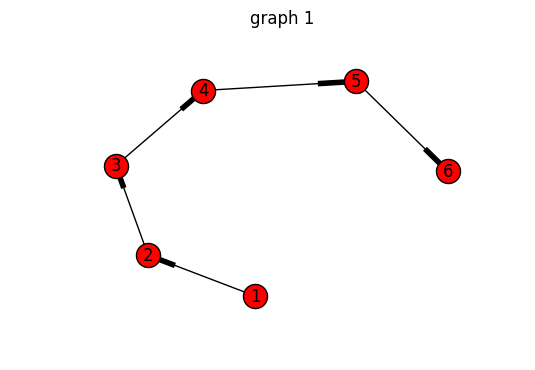

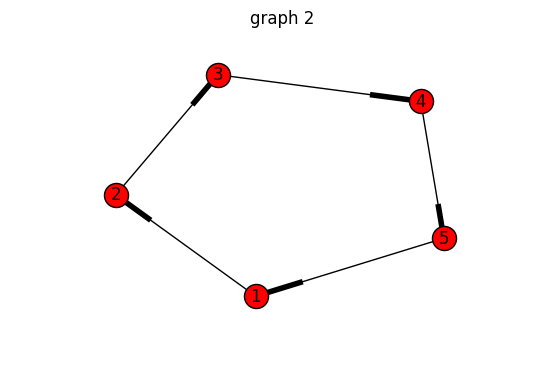

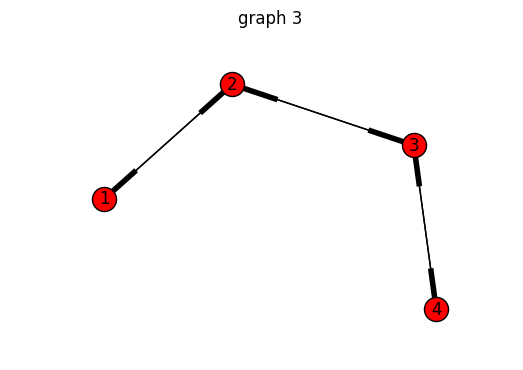

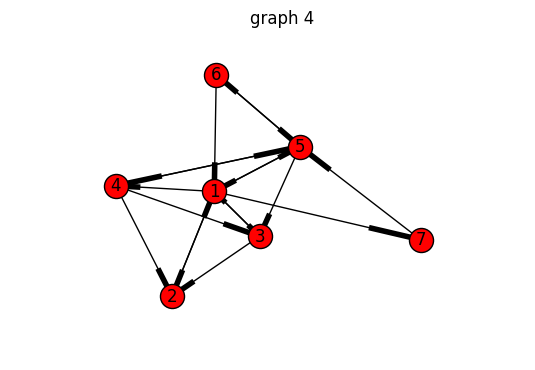

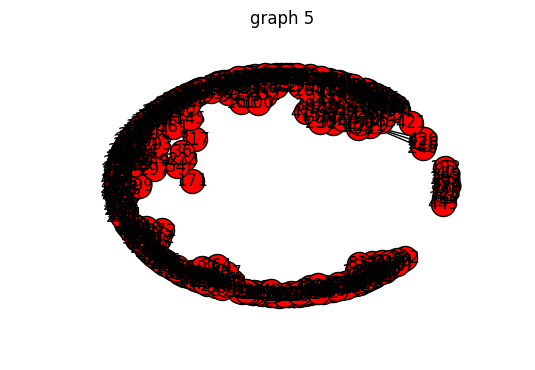

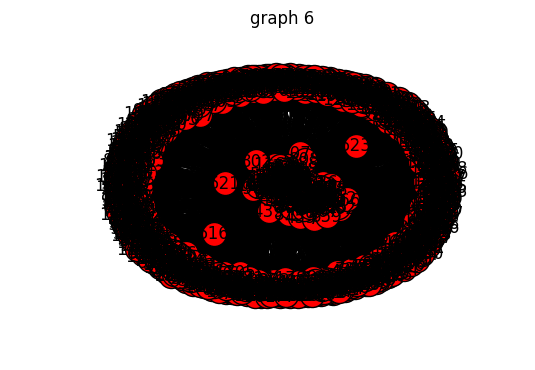

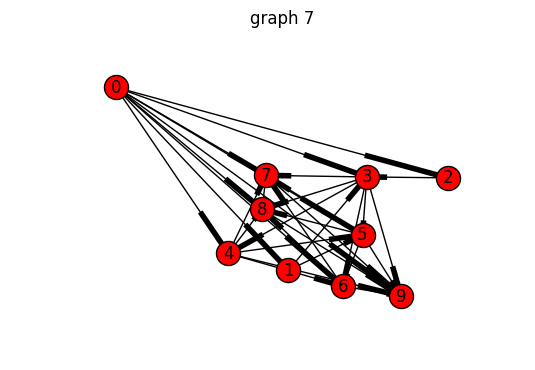

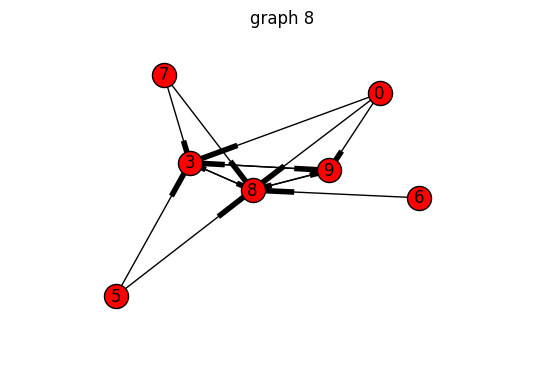

In [8]:
visualize_graphs(graphs)

---

# Algorithm  Implementation

## <a name='hits'></a> Hits

### Self Implement of HITS (1)

In [9]:
def initGraph(G):
    for node in G:
        G.add_node(node, authority=1)
        G.add_node(node, hub=1)
    return G

In [10]:
def normalized(G, h, a):
    totalH, totalA, t = 0, 0, 0
    for node in G:
        totalH += h[node]
        totalA += a[node]
    for node in G:
        #t += abs(h[node] / totalH - G.node[node]['hub'])
        t += abs(a[node] / totalA - G.node[node]['authority'])
        G.node[node]['hub'] = h[node] / totalH
        G.node[node]['authority'] = a[node] / totalA
    return G,t

In [11]:
def authorityHub(G, h, a):
    for node in G:
        h[node], a[node] = 0,0
        for ch in G.successors(node):
            h[node] += G.node[ch]['authority']
        for pa in G.predecessors(node):
            a[node] += G.node[pa]['hub']
    G,t = normalized(G,h,a)
    return G,h,a,t

In [12]:
def HITS(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    h, a = {}, {}
    initGraph(G)
    it, t = 0, 1
    while it < max_iter and t > tol:
        G,h,a,t = authorityHub(G,h,a)
        print(it,t)
        it += 1
    for node in G:
        h[node] = G.node[node]['hub']
        a[node] = G.node[node]['authority']        
    return h,a

### Self Implement of HITS (2)

In [13]:
def maximal(m):
    #total = np.sqrt(np.sum(np.square(np.abs(m))))
    maximum = np.max(np.abs(m))
    return m/maximum #total

In [14]:
def normal(m):
    total = np.sum(np.abs(m))
    return m/total

In [15]:
def compare(m1, m2):
    result = np.sum(np.abs(m1-m2))
    return result

In [16]:
def hits(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    k = G.number_of_nodes()
    nodeDict, Hub, Auth = {}, {}, {}
    i, it, t = 0, 0, 1
    for node in G:
        nodeDict[node] = i
        i += 1
        
    A = np.zeros((k, k))
    for node in G:    
        for n in G.neighbors(node):
            A[nodeDict[node]][nodeDict[n]] = 1
    A.shape=(k,k)  
    AT = np.transpose(A)
    
    h = np.ones((k,1))/k
    a = np.ones((k,1))/k 
    
    while it <= max_iter and t > tol:
        pre_h = h
        a = maximal(AT.dot(pre_h))
        h = maximal(A.dot(a))
    
        t = compare(h, pre_h)# + compare(a, pre_a)
        it += 1
    
    h = normal(h)
    a = normal(a)
    for key in nodeDict.keys():
        Hub[key] = h[nodeDict[key]][0]
        Auth[key] = a[nodeDict[key]][0]
        
    return Hub, Auth

HITS algorithm is implemented in two-way.  
The difference between them is the way to store the weight of hub and authority.   
The former implementation stores them in the graph while the latter one store them in matrixes, which improving the efficiency of calculating the weights.  
The main concept of implementing HITS is the same, so I will focus on the second implementation in the following paragraphs.  
* Step 1: create a matrix A to store the connection(links) between nodes.  
* Step 2: take two matrices as scores of hub and authority whose dimension are both k x 1 where k represents the number of nodes and initialize all of the element with 1.  
* Step 3: update the score of authority with the dot product of the transpose of A and the score of hub.  
* Step 4: update the score of hub with the dot product of A and the new score of authority.  
* Step 5: normalize them and calculate the tolerance. if the tolerance is too high and iteration counter is lower than max_iter, repeat the step2~5.  


## <a name='pagerank'></a> Page Rank

In [17]:
def pagerank(graph: nx.classes.digraph.DiGraph,
             *, alpha: float = 0.85, epsilon: float = 1e-06) -> Dict[object, float]:
    """Page Rank
    
    Args:
        graph: Networkx Directed Graph
        alpha: 1 - damping factor
        epsilon: The threshold to teminate iterations
        
    Returns:
        Pageranks of each nodes
    """
    
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    out_degs = np.sum(adj_matrix, axis=1)
    damping_factor = 1 - alpha
    
    # Nodes with no outgoing edges
    dangle_nodes = [
        index
        for index, o_deg in enumerate(graph.out_degree().values())
        if not o_deg
    ]
    
    # Page Ranks
    prs = np.array([1/node_num for _ in range(node_num)])
    # Page Ranks in previous iteration
    pre_prs = np.array([0 for _ in range(node_num)])
    
    delta = np.sum(np.abs(prs - pre_prs))
    while delta > epsilon:
        pre_prs = deepcopy(prs)
        
        # Page Rank values each node can contribute in each edge
        pr_quotas = np.array(
            [pr/deg if deg else 0 for pr, deg in zip(pre_prs, out_degs)]
        )
        dangle_sum = np.sum([pre_prs[dangle_node]/node_num
                             for dangle_node in dangle_nodes])

        prs = (
            damping_factor / node_num +
            alpha *
            (
                pr_quotas.dot(adj_matrix) + 
                dangle_sum
            )
        )
        
        # Normalize
        prs /= np.sum(prs)
        delta = np.sum(np.abs(prs - pre_prs))
        
    # Mapping node name to its page rank
    prs_mappping = {node: pr for node, pr in zip(graph.nodes(), prs)}
    return prs_mappping

This implementation is based on the following formula

$$ PR(p_i) = {\frac{1-d}{N}} + d(\sum_{p_j\ links\ to\ p_i}{\frac{PR(p_j)}{L(p_j)}} + \sum_{p_j\ has\ no\ out-links}{\frac{PR(p_j)}{N}})$$


In each iteration, I first calculate the pageranks that each node can contribute in each edge.  
e.g. The pagerank of node 1 is 0.5 and node 1 has 2 outgoing edges. Then, pagerank quota of node 1 would be 0.5/2 = 0.25

Next, I calculate the dot product of pagerank quotas and adjacency matrix of the graph.  
By doing this, the pagerank quotas are distributed to each ingoing link.  
The result would be the $\sum\limits_{p_j\ links\ to\ p_i}{\frac{PR(p_j)}{N}}$ part.

After that, the pagerank values of all dangling nodes (i.e. nodes with no outgoing edges) are divided by numbers of nodes and then summed up as `dangle_sum`.
This would be the $\sum\limits_{p_j\ has\ no\ out-links}{\frac{PR(p_j)}{L(p_j)}})$ part.

Add this two part, multiply damping factor, add ${\frac{1-d}{N}}$ and then we will get the pagerank result of this iteration.

Repeat these steps until the difference between pagerank and pagerank in the previous iteration is smaller than epsilon.

### Reference 
[PageRank Lecture Note](http://www.ccs.northeastern.edu/home/daikeshi/notes/PageRank.pdf)

## <a name='simrank'></a> SimRank

In [18]:
np.seterr(divide='ignore', invalid='ignore')

def simrank(graph, *, C=0.8, epsilon=1e-06):
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    adj_matrix /= np.sum(adj_matrix, axis=0)
    adj_matrix = np.nan_to_num(adj_matrix)
    
    pre_sim = np.zeros(node_num)
    sim = np.eye(node_num)
    delta = np.sum(np.abs(sim - pre_sim))
    while delta > epsilon:
        pre_sim = deepcopy(sim)
        sim = C * adj_matrix.transpose().dot(pre_sim).dot(adj_matrix)
        for i in range(node_num):
            sim[i, i] = 1
        delta = np.sum(np.abs(sim - pre_sim))
    return sim

The implementation is based on this formula.

$$ S = max\{C \cdot (A^T \cdot S\cdot A), I\}$$

$A$ is the normalized adjacency matrix whose entry

$$ A[a,b]=\left\{
\begin{aligned}
{\frac{1}{|I(b)|}},\ \text{Edge(a, b) exists}\\
0,\ \text{Otherwise}
\end{aligned}
\right.
$$

### Reference
[SimRank - Matrix representation of SimRank](https://en.wikipedia.org/wiki/SimRank#Matrix_representation_of_SimRank)

---

# <a name='discussion'></a> Discussion

## <a name='result'></a> Result Analysis

### Hits

In [19]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    h,a = hits(graph, np.inf)
    print('hub:')
    pp.pprint(h)
    print('authority:')
    pp.pprint(a)


Graph 1
hub:
{   '1': 0.20000000000000001,
    '2': 0.20000000000000001,
    '3': 0.20000000000000001,
    '4': 0.20000000000000001,
    '5': 0.20000000000000001,
    '6': 0.0}
authority:
{   '1': 0.0,
    '2': 0.20000000000000001,
    '3': 0.20000000000000001,
    '4': 0.20000000000000001,
    '5': 0.20000000000000001,
    '6': 0.20000000000000001}

Graph 2
hub:
{   '1': 0.20000000000000001,
    '2': 0.20000000000000001,
    '3': 0.20000000000000001,
    '4': 0.20000000000000001,
    '5': 0.20000000000000001}
authority:
{   '1': 0.20000000000000001,
    '2': 0.20000000000000001,
    '3': 0.20000000000000001,
    '4': 0.20000000000000001,
    '5': 0.20000000000000001}

Graph 3
hub:
{   '1': 0.19098300566477841,
    '2': 0.30901699433522162,
    '3': 0.30901699433522162,
    '4': 0.19098300566477841}
authority:
{   '1': 0.19098300552104899,
    '2': 0.30901699447895098,
    '3': 0.30901699447895098,
    '4': 0.19098300552104899}

Graph 4
hub:
{   '1': 0.2754531765654345,
    '2': 0.047

### Page Rank

In [20]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(pagerank(graph))


Graph 1
{   '1': 0.060716150359376497,
    '2': 0.11232492783068009,
    '3': 0.15619235710247789,
    '4': 0.1934794507762447,
    '5': 0.22517347758916137,
    '6': 0.25211363634205947}

Graph 2
{   '1': 0.20000000000000001,
    '2': 0.20000000000000001,
    '3': 0.20000000000000001,
    '4': 0.20000000000000001,
    '5': 0.20000000000000001}

Graph 3
{   '1': 0.17543856058862933,
    '2': 0.32456143941137072,
    '3': 0.32456143941137072,
    '4': 0.17543856058862933}

Graph 4
{   '1': 0.2802878551778531,
    '2': 0.15876446265602656,
    '3': 0.13888181220259527,
    '4': 0.10821960072742003,
    '5': 0.1841980970801137,
    '6': 0.060570694570464545,
    '7': 0.069077477585526917}

Graph 5
{   '1': 0.0016245250513358374,
    '10': 0.0019580859328310993,
    '100': 0.0017254905857974148,
    '101': 0.0016808649407226066,
    '102': 0.0016827295493964385,
    '103': 0.0017160824498525221,
    '104': 0.0098906888285717424,
    '105': 0.0026157147843418899,
    '106': 0.0019669095646

- If the directed graph is a cycle(e.g. graph 2), then pagerank of all nodes would be the same.
- If the graph is symmetry, the corresponding nodes would have the same pagerank

### Sim Rank

In [21]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(simrank(graph))


Graph 1
array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

Graph 2
array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

Graph 3
array([[ 1.        ,  0.66666655,  0.        ,  0.        ],
       [ 0.66666655,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.66666655],
       [ 0.        ,  0.        ,  0.66666655,  1.        ]])

Graph 4
array([[ 1.        ,  0.4122407 ,  0.45405216,  0.29239227,  0.53506349,
         0.27012699,  0.4510382 ],
       [ 0.4122407 ,  1.        ,  0.41218164,  0.33765876,  0.3426946 ,
         0.27314849,  0.39005383],
       [ 0.45405216,  0.41218164,  1.        ,  0.3602648 ,  0.36974703,
         0.2854419 ,  0.

If no nodes point to the same node, the result of SimRank would still be the identify matrix as initialized.

## <a name='performance'></a> Computation Performance Analysis

### Time

- Hits  
  
Compared with networkx.hits, self-implemented HITS has shorter execution time because it calculates the recursive computation of dot product with numpy.matrix instead of calculating and summing up the dot product value by value like networkx does.

In [22]:
%%time

for graph in graphs:
    hits(graph, np.inf)

CPU times: user 323 ms, sys: 17.2 ms, total: 341 ms
Wall time: 203 ms


In [23]:
%%time

for graph in graphs:
    nx.hits(graph, np.inf)

CPU times: user 1.3 s, sys: 4.21 ms, total: 1.31 s
Wall time: 1.31 s


- Page Rank

I compare my implementation of pagerank with a well-known library - networkx and found that my implementation is faster.  
By digging into source code, I found one possible reason is that networkx's implementation is more flexible.  
(e.g. It considers the weight of each edge)  
Another reason might be that networks's implementation uses `dict` to store values which is much slower than using `numpy` which is used in my implementation.

In [24]:
%%time

for graph in graphs:
    pagerank(graph)

CPU times: user 58.4 ms, sys: 11.4 ms, total: 69.7 ms
Wall time: 59.6 ms


In [25]:
%%time

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

CPU times: user 72 ms, sys: 2.24 ms, total: 74.3 ms
Wall time: 73.4 ms


- SimRank

In [26]:
%%time

for graph in graphs:
    simrank(graph)

CPU times: user 50.8 s, sys: 1.54 s, total: 52.4 s
Wall time: 17.9 s


### Memory

- Hits  
  
The peak memory of both implementations is almost the same.

In [27]:
%%memit

for graph in graphs:
    hits(graph, np.inf)

peak memory: 127.50 MiB, increment: 11.36 MiB


In [28]:
%%memit

for graph in graphs:
    nx.hits(graph, np.inf)

peak memory: 127.51 MiB, increment: 0.01 MiB


- Page Rank

The peak memory of both implementaion is close.

In [29]:
%%memit

for graph in graphs:
    pagerank(graph)

peak memory: 140.20 MiB, increment: 12.69 MiB


In [30]:
%%memit

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

peak memory: 141.64 MiB, increment: 1.69 MiB


- SimRank

In [31]:
%%memit

for graph in graphs:
    simrank(graph)

peak memory: 179.02 MiB, increment: 37.38 MiB


## <a name='increase-hub-authority'></a> Find a way to increase hub, authority

### Graph 1

In [32]:
g1 = deepcopy(graphs[0])
h1, a1 = hits(g1)
print("original hub =", h1['1'])
print("original authority =", a1['1'])

original hub = 0.2
original authority = 0.0


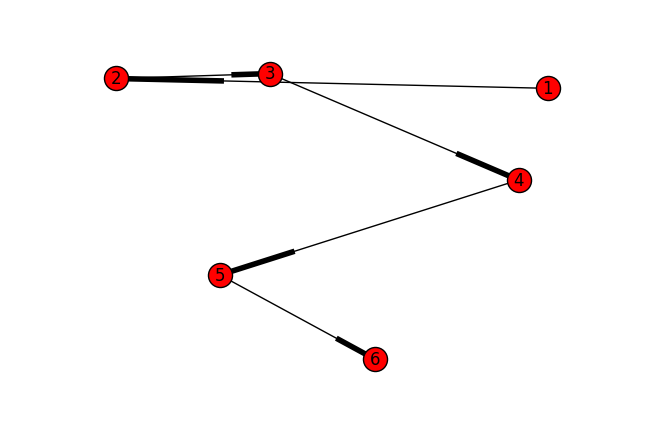

In [33]:
nx.draw(g1,with_labels=True)
plt.show()

### To increase hub:

Method 1. Add a link point to node '1' from itself.

In [34]:
g1_h1= deepcopy(graphs[0])
g1_h1.add_edge('1', '1')
print("original hub =", h1['1'])
print("new hub =",hits(g1_h1)[0]['1'])

original hub = 0.2
new hub = 0.999999992549


Method 2. Add an edge from node '1' point to other nodes if the existence of the link will increase the score of hub.

In [35]:
g1_h2= deepcopy(graphs[0])
print("original hub =", h1['1'])
h = h1['1']
for node in g1_h2.nodes():
    if node not in g1_h2.neighbors('1'):
        if node is '1':
            continue
        g1_h2.add_edge('1', node)
        new_h = hits(g1_h2)[0]['1']
        if new_h <= h:
            g1_h2.remove_edge('1',node)
        else:
            h = new_h
            print("add edge ( 1 ,",node,")", h)
print("new hub =", h)

original hub = 0.2
add edge ( 1 , 5 ) 0.618033987116
new hub = 0.618033987116


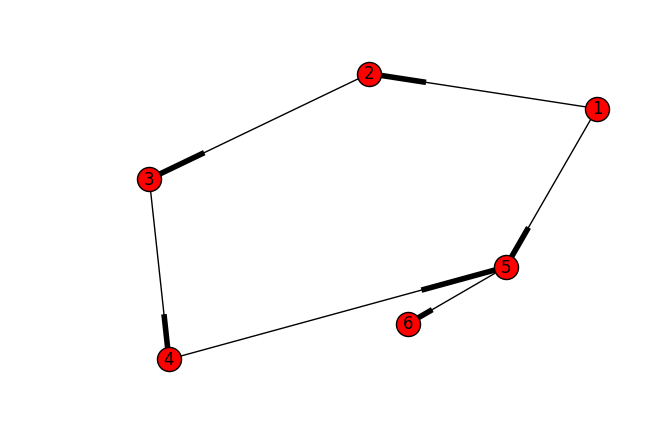

In [36]:
nx.draw(g1_h2,with_labels=True)
plt.show()

### To increase authority:

Method 1. Add a link point to node '1' to itself.

In [37]:
g1_a1= deepcopy(graphs[0])
g1_a1.add_edge('1', '1')
print("original authority =", a1['1'])
print("new authority =",hits(g1_a1)[1]['1'])

original authority = 0.0
new authority = 0.499999996275


Method 2. Add an edge from other nodes to node '1' if the existence of the link will increase the score of authority.

In [38]:
g1_a2= deepcopy(graphs[0])
print("original authority =", a1['1'])
a = a1['1']
for node in g1_a2.nodes():
    if node not in g1_a2.neighbors('1'):
        if node is '1':
            continue
        g1_a2.add_edge(node, '1')
        new_a = hits(g1_a2)[1]['1']
        if new_a <= a:
            g1_a2.remove_edge(node, '1')
        else:
            a = new_a
            print("add edge (",node,"1 )", a)
print("new authority =", a)

original authority = 0.0
add edge ( 5 1 ) 0.499999996275
add edge ( 4 1 ) 0.499999999032
add edge ( 6 1 ) 0.577350268294
new authority = 0.577350268294


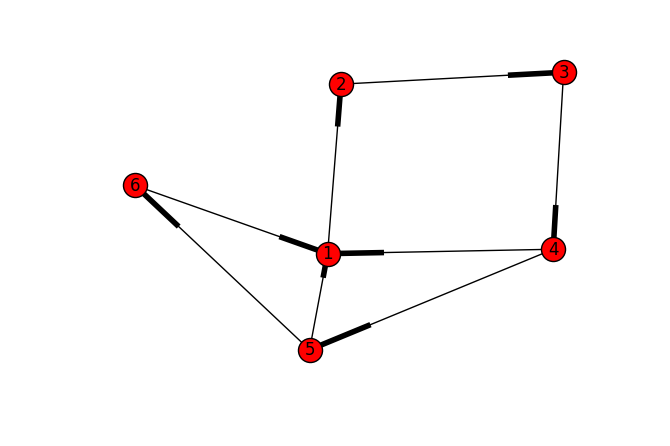

In [39]:
nx.draw(g1_a2,with_labels=True)
plt.show()

### Graph 2

In [40]:
g2 = deepcopy(graphs[1])
h2, a2 = hits(g2)
print("original hub =", h2['1'])
print("original authority =", a2['1'])

original hub = 0.2
original authority = 0.2


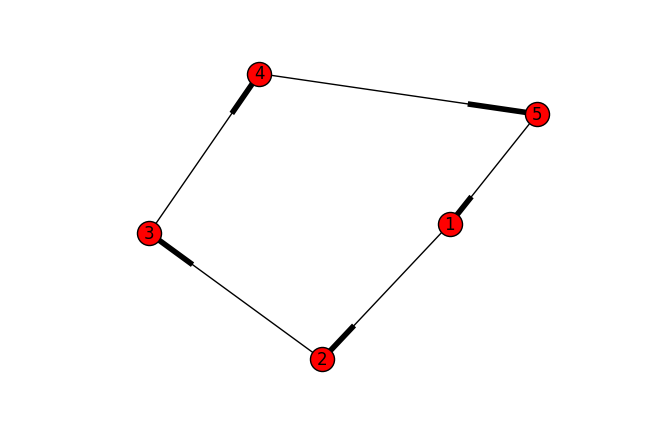

In [41]:
nx.draw(g2,with_labels=True)
plt.show()

### To increase hub:

Method 1

In [42]:
g2_h1= deepcopy(graphs[1])
g2_h1.add_edge('1', '1')
print("original hub =", h2['1'])
print("new hub =",hits(g2_h1)[0]['1'])

original hub = 0.2
new hub = 0.618033987116


Method 2

In [43]:
g2_h2= deepcopy(graphs[1])
print("original hub =", h2['1'])
h = h2['1']
for node in g2_h2.nodes():
    if node not in g2_h2.neighbors('1'):
        if node is '1':
            continue
        g2_h2.add_edge('1', node)
        new_h = hits(g2_h2)[0]['1']
        if new_h <= h:
            g2_h2.remove_edge('1',node)
        else:
            h = new_h
            print("add edge ( 1 ,",node,")", h)
print("new hub =", h)

original hub = 0.2
add edge ( 1 , 5 ) 0.618033987116
new hub = 0.618033987116


### To increase authority:

Method 1

In [44]:
g2_a1= deepcopy(graphs[1])
g2_a1.add_edge('1', '1')
print("original authority =", a2['1'])
print("new authority =",hits(g2_a1)[1]['1'])

original authority = 0.2
new authority = 0.618033986106


Method 2

In [45]:
g2_a2= deepcopy(graphs[1])
print("original authority =", a2['1'])
a = a2['1']
for node in g2_a2.nodes():
    if node not in g2_a2.neighbors('1'):
        if node is '1':
            continue
        g2_a2.add_edge(node, '1')
        new_a = hits(g2_a2)[1]['1']
        if new_a <= a:
            g2_a2.remove_edge(node, '1')
        else:
            a = new_a
            print("add edge (",node,"1 )", a)
print("new authority =", a)

original authority = 0.2
add edge ( 4 1 ) 0.499999997206
add edge ( 3 1 ) 0.499999999355
new authority = 0.499999999355


### Graph 3

In [46]:
g3 = deepcopy(graphs[2])
h3, a3 = hits(g3)
print("original hub =", h2['3'])
print("original authority =", a2['3'])

original hub = 0.2
original authority = 0.2


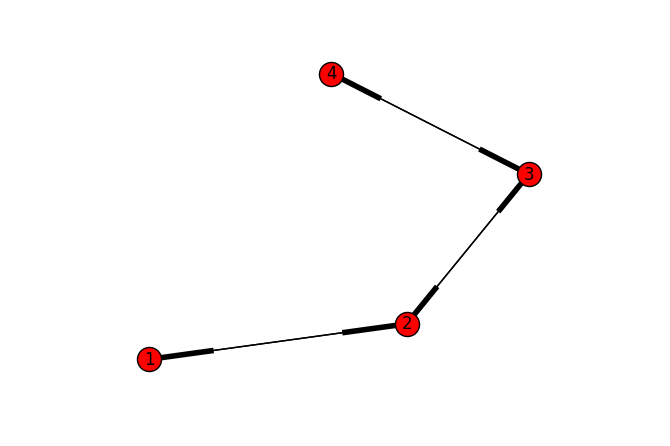

In [47]:
nx.draw(g3,with_labels=True)
plt.show()

### To increase hub:

Method 1

In [48]:
g3_h1= deepcopy(graphs[2])
g3_h1.add_edge('1', '1')
print("original hub =", h3['1'])
print("new hub =",hits(g3_h1)[0]['1'])

original hub = 0.190983005665
new hub = 0.347296354603


Method 2

In [49]:
g3_h2= deepcopy(graphs[2])
print("original hub =", h3['1'])
h = h3['1']
for node in g3_h2.nodes():
    if node not in g3_h2.neighbors('1'):
        if node is '1':
            continue
        g3_h2.add_edge('1', node)
        new_h = hits(g3_h2)[0]['1']
        if new_h <= h:
            g3_h2.remove_edge('1',node)
        else:
            h = new_h
            print("add edge ( 1 ,",node,")", h)
print("new hub =", h)

original hub = 0.190983005665
add edge ( 1 , 4 ) 0.499999996236
new hub = 0.499999996236


### To increase authority:

Method 1

In [50]:
g3_a1= deepcopy(graphs[2])
g3_a1.add_edge('1', '1')
print("original authority =", a3['1'])
print("new authority =",hits(g3_a1)[1]['1'])

original authority = 0.190983005521
new authority = 0.34729635623


Method 2

In [51]:
g3_a2= deepcopy(graphs[2])
print("original authority =", a3['1'])
a = a3['1']
for node in g3_a2.nodes():
    if node not in g3_a2.neighbors('1'):
        if node is '1':
            continue
        g3_a2.add_edge(node, '1')
        new_a = hits(g3_a2)[1]['1']
        if new_a <= a:
            g3_a2.remove_edge(node, '1')
        else:
            a = new_a
            print("add edge (",node,"1 )", a)
print("new authority =", a)

original authority = 0.190983005521
add edge ( 4 1 ) 0.499999995347
new authority = 0.499999995347


### Brief Conclusion
- Hub:
    - The main idea of increasing score of hub is based on "A good hub is a site that links to many authoritative sites", so I increase the number of outgoing edges of node 1 with the constraints of higher hubness. 
    - Method 1: It cuts corners to add a link from 1 to 1 which is significantly useful only in graph 1.
    - Method 2: This method is more effective in all of three graphs than method 1.
- Authority:
    - Following the concept that "A site is very authoritative if it receives many citations," I use the following method to increase the number of nodes which point to node 1.
    - Method 1: This method performs better only in graph 2 which is a circular graph.
    - Method 2: In average, it elevates all the score of authority in all graph above.

## <a name='increase-pagerank'></a> Find a way to increase pagerank

The goal of this section is to increase pagerank of node 1.  
Since modifying others' links is not that practical in the real world, the operation here would only consider manipulating edge of node 1.

### Graph 1

In [52]:
g1 = deepcopy(graphs[0])

In [53]:
g1_original_pagerank = pagerank(g1)
g1_original_pagerank

{'1': 0.060716150359376497,
 '2': 0.11232492783068009,
 '3': 0.15619235710247789,
 '4': 0.1934794507762447,
 '5': 0.22517347758916137,
 '6': 0.25211363634205947}

- Add an edge from node 1 to another

In [54]:
for dest in ['3', '4', '5', '6']:
    g1.add_edge('1', dest)
    print("Page Rank after adding edge 1 -> {dest}:".format(dest=dest), pagerank(g1)['1'])
    g1.remove_edge('1', dest)

Page Rank after adding edge 1 -> 3: 0.0615451114639
Page Rank after adding edge 1 -> 4: 0.0625498732763
Page Rank after adding edge 1 -> 5: 0.0637747942557
Page Rank after adding edge 1 -> 6: 0.0652786918357


As the result shows, by adding edge (1, 3) and (1, 6) can increase pagerank of node 1.

### Graph 2

In [55]:
g2 = deepcopy(graphs[1])

In [56]:
g2_origin_pagerank = pagerank(g2)
g2_origin_pagerank

{'1': 0.20000000000000001,
 '2': 0.20000000000000001,
 '3': 0.20000000000000001,
 '4': 0.20000000000000001,
 '5': 0.20000000000000001}

- Add an edge from node 1 to another

In [57]:
for dest in ['3', '4', '5', '6']:
    g2.add_edge('1', dest)
    print("Page Rank after adding edge 1 -> {dest}:".format(dest=dest), pagerank(g2)['1'])
    g2.remove_edge('1', dest)

Page Rank after adding edge 1 -> 3: 0.215140813314
Page Rank after adding edge 1 -> 4: 0.236176152488
Page Rank after adding edge 1 -> 5: 0.266873610439
Page Rank after adding edge 1 -> 6: 0.208528534572


As the result shows, by adding an edge from node 1 to any other node increases pagerank of node 1.  
The impact of the added edge grows stronger when the destination node of it can link to node 1 in a shorter path.

### Graph 3

In [58]:
g3 = deepcopy(graphs[2])

In [59]:
g3_origin_pagerank = pagerank(g3)
g3_origin_pagerank

{'1': 0.17543856058862933,
 '2': 0.32456143941137072,
 '3': 0.32456143941137072,
 '4': 0.17543856058862933}

- Add an edge from node 1 to another

In [60]:
for dest in ['3', '4']:
    g3.add_edge('1', dest)
    print("Page Rank after adding edge 1 -> {dest}:".format(dest=dest), pagerank(g3)['1'])
    g3.remove_edge('1', dest)

Page Rank after adding edge 1 -> 3: 0.149973195546
Page Rank after adding edge 1 -> 4: 0.14375


Adding node from node 1 to any other node cannot increase pagerank of node 1.

- Remove an edge from node 1 while not making it become isolated

In [61]:
g3.remove_edge('1', '2')
print("Page Rank after removing edge 1 -> 2: ", pagerank(g3)['1'])
g3.add_edge('1', '2')

Page Rank after removing edge 1 -> 2:  0.171884504545


As the result shows, by removing edge (1, 2) can increase pagerank

### Findings
- If one page is linked by others, then linking to these pages would increase its pagerank.  
  If not directly linked, linking to the pages whose path to this page are shorter would have a stronger effect.  
  This happens due to the fact that one's pankrank is decided by others.  
  If this page contributes more to pages that can contribute more to itself (i.e. pages whose path is shorter to this page), then its rank would be higher.
- If one page is not linked by others but links to others, then by breaking these links it would get a higher pagerank.  
  Because it can share distributed ranking value of dangling nodes instead of contributing all these values to others.

## <a name='important'></a> Can link analysis algorithms really find the “important” pages from Web?

According to section [Find a way to increase hub, authority](#increase-hub-authority) and section [Find a way to increase pagerank](#increase-pagerank), it's possible to manipulate the important of these values.  
Thus, we can hardly say these algorithms can find the really important pages from Web.  
  
Besides, these algorithms consider only relationships between pages instead of their content which might be one of the crucial indicators of deciding which pages are important.

## <a name='c-in-simrank'></a> What is the effect of “C” parameter in SimRank?

Consider the following scenario

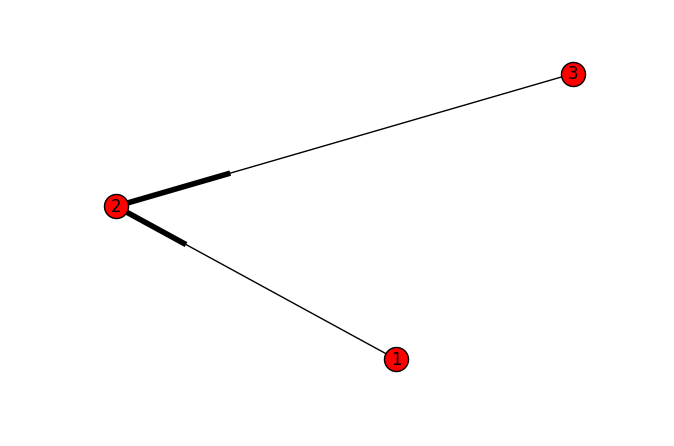

In [62]:
Gt = nx.DiGraph()
Gt.add_edge(1, 2)
Gt.add_edge(3, 2)
nx.draw(Gt, with_labels=True)

We would say that S(1, 3) might be high since they link to the same node. This is the basic idea of SimRank.  
However, we probably won't conclude that $S(1,3) = S(2,2) = 1$  
Node 1 and 3 might be similar but the similarity should not be the same as identical nodes'.  
Thus, the decay factor C whose value is between 0 and 1 can be used to handle this problem

### Reference
[SimRank: A Measure of Structural-Context Similiarity](http://dc-pubs.dbs.uni-leipzig.de/files/Jeh2002SimRankameasureof.pdf)

## <a name='practical-issue'></a> What are practical issues when implement these algorithms in a real Web?   
  
In the real world, I think that efficiency is sometimes more important than accuracy.  
That's to say, while we consider to raise the values of hubness and authority in HITS as high as possible, and so does pagerank and simrank in experiment, what does matter may be the fact that users cannot wait more than ten seconds after pressing the "return" and expecting for the result on the search engine.  
Therefore, the practical issue is how to get the query results with not low relevance and highest effciency.
There will be a trade-off among short response time and authoritative website when applying the algorithm in real Web.

# <a name='conclusion'></a> Conclusion

After implementing these algorithms about link analysis, we find out that it is not easy to attract what's really important and relevant among so many websites on the Internet.  
The algorithms we implement in project 3 have different characteristics and suitable situations, so we should apply them into fitting conditions for highest performance. 